In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os, glob, itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
from torchvision.utils import save_image

In [ ]:
# with zipfile.ZipFile("/content/drive/My Drive/SRGAN/Checkpoints/drive-download-20230311T015403Z-001.zip", 'r') as zObject:
#     zObject.extractall(path="/content/drive/My Drive/SRGAN/Checkpoints/")

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, paths, lr_shape, hr_shape):
        self.lr_height, self.lr_width = lr_shape
        self.hr_height, self.hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((self.lr_height, self.lr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((self.hr_height, self.hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.paths = paths

    def __getitem__(self, index):
        path = self.paths[index % len(self.paths)]
        img_hr = Image.open(path)
        img_lr = Image.open("/content/drive/My Drive/SRGAN/train/DIV2K_train_LR_unknown/X2/" + path.split('/')[-1].split('.')[0] + "x2.png")
        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.paths)

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16,
                 n_residual_features=64):
        super(Generator, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=n_residual_features,
                            kernel_size=9, stride=1, padding=4),
            torch.nn.PReLU(),
        )

        class ResidualBlock(torch.nn.Module):
            def __init__(self, n_features=64):
                super(ResidualBlock, self).__init__()

                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=n_features, out_channels=n_features,
                                    kernel_size=3, stride=1, padding=1),
                    torch.nn.BatchNorm2d(num_features=n_features),
                    torch.nn.PReLU(),
                    torch.nn.Conv2d(in_channels=n_features, out_channels=n_features,
                                    kernel_size=3, stride=1, padding=1),
                    torch.nn.BatchNorm2d(num_features=n_features),
                )

            def forward(self, x):
                out = torch.add(x, self.block(x))
                return out

        self.res_blocks = torch.nn.ModuleList()
        for _ in range(n_residual_blocks):
            self.res_blocks.append(ResidualBlock(n_features=n_residual_features))

        # self.residual_blocks = torch.nn.Sequential(*res_blocks)

        self.res_conv = torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features,
                            kernel_size=1, stride=1, padding=0)

        self.up_sampler = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features*4,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(num_features=n_residual_features*4),
            torch.nn.PixelShuffle(upscale_factor=2),
            torch.nn.PReLU(),
            # torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features*4,
            #                 kernel_size=3, stride=1, padding=1),
            # torch.nn.BatchNorm2d(num_features=n_residual_features*4),
            # torch.nn.PixelShuffle(upscale_factor=2),
            # torch.nn.PReLU(),
        )

        self.conv2 = torch.nn.Conv2d(in_channels=n_residual_features, out_channels=out_channels,
                            kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        res_sum = None
        for rb in self.res_blocks:
            x1 = rb(x1)
            if res_sum is None:
                res_sum = self.res_conv(x1)
            else:
                res_sum = torch.add(self.res_conv(x1), res_sum)

        x2 = self.up_sampler(res_sum)
        x3 = self.conv2(x2)
        out = torch.tanh(x3)

        return out

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, True),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(131072, 1024),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Linear(1024, 1),
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = torch.flatten(x1, 1)
        out = self.classifier(x2)

        return out

In [ ]:
class VGGFeatureMap(torch.nn.Module):
    def __init__(self):
        super(VGGFeatureMap, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg_layer = torch.nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, x):
        return self.vgg_layer(x)

In [ ]:
train_dataset_path = "/content/drive/My Drive/SRGAN/train/DIV2K_train_HR"
train_paths = glob.glob(train_dataset_path + "/*.*")
train_dataset = ImageDataset(train_paths, (128, 128), (256, 256))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
print(dev)
device = torch.device(dev)

cuda:0


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# vgg_fm = VGGFeatureMap().to(device)
generator.load_state_dict(torch.load("/content/drive/My Drive/SRGAN/Checkpoints3/generator_current.pth"))
discriminator.load_state_dict(torch.load("/content/drive/My Drive/SRGAN/Checkpoints3/discriminator_current.pth"))

<All keys matched successfully>

In [ ]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
adversarial_criterion = torch.nn.BCEWithLogitsLoss().to(device)
content_criterion = torch.nn.MSELoss().to(device)

In [ ]:
# f = open("/content/drive/My Drive/SRGAN/Checkpoints3/logs.txt", "x")

In [ ]:
n_epochs = 500
n_epoch_start = 451
batch_size = 4

In [ ]:
for epoch in range(n_epoch_start, n_epochs+1):
    print(epoch)
    g_epoch_loss = 0
    d_epoch_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for idx, imgs in enumerate(train_dataloader):
        print(idx)
        lr_input = imgs["lr"].to(device)
        hr_input = imgs["hr"].to(device)

        real_label = torch.full([batch_size, 1], 1.0, dtype=lr_input.dtype).to(device)
        fake_label = torch.full([batch_size, 1], 0.0, dtype=lr_input.dtype).to(device)

        generator.zero_grad()
        hr_generator_output = generator(lr_input)
        # .clamp(min=0.0, max=1.0)

        rmse_loss = content_criterion(hr_generator_output, hr_input)
        vgg_loss = content_criterion(vgg_fm(hr_generator_output), vgg_fm(hr_input).detach())
        adversarial_loss = adversarial_criterion(discriminator(hr_generator_output).clamp(min=0.0, max=1.0), real_label)
        generator_loss = rmse_loss + 0.0001*vgg_loss + 0.01*adversarial_loss
        # generator_loss = rmse_loss + 0.004*vgg_loss
        # print(rmse_loss.item(), vgg_loss.item(), adversarial_loss.item(), generator_loss.item())
        # break
        generator_loss.backward()
        g_optimizer.step()

        discriminator.zero_grad()
        discriminator_loss_real = adversarial_criterion(discriminator(hr_input).clamp(min=0.0, max=1.0), real_label)
        discriminator_loss_fake = adversarial_criterion(discriminator(hr_generator_output.detach()).clamp(min=0.0, max=1.0), fake_label)
        discriminator_loss = (discriminator_loss_fake + discriminator_loss_real)/2
        discriminator_loss.backward()
        d_optimizer.step()

        g_epoch_loss += generator_loss.item()
        # d_epoch_loss += 0
        d_epoch_loss += discriminator_loss.item()

        if idx % 40 == 0:
            torch.save(generator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints3/generator_current.pth")
            torch.save(discriminator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints3/discriminator_current.pth")

    # break
    g_epoch_loss = g_epoch_loss/200
    d_epoch_loss = d_epoch_loss/200
    # print(epoch, d_epoch_loss)
    f = open("/content/drive/My Drive/SRGAN/Checkpoints3/logs.txt", "a")
    f.write("Epoch {}: Generator Loss: {}, Discriminator Loss: {}\n".format(epoch, g_epoch_loss, d_epoch_loss))
    f.close()
    with torch.no_grad():
        valid_imgs = train_dataset[420]
        valid_input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
        valid_output_hr = generator(valid_input_lr.to(device))
        inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
        pred_output = inv_norm(valid_output_hr[0])
        save_image(pred_output, '/content/drive/My Drive/SRGAN/Checkpoints3/{}.png'.format(epoch))

Streaming output truncated to the last 5000 lines.
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
457
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
13

FileNotFoundError: ignored

In [ ]:
valid_imgs = train_dataset[550]
inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
# hr = torch.unsqueeze(lr, dim=0)
with torch.no_grad():
    output_hr = generator(input_lr.to(device))

In [ ]:
plt.imshow(inv_norm(valid_imgs["lr"]).permute(1, 2, 0))

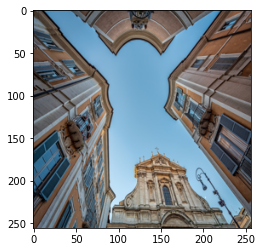

In [ ]:
plt.imshow(inv_norm(valid_imgs["hr"]).permute(1, 2, 0))

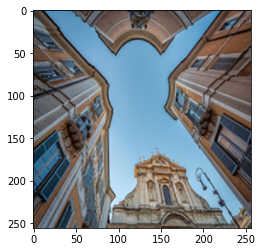

In [ ]:
plt.imshow(inv_norm(output_hr[0]).permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
input_hr = torch.unsqueeze(valid_imgs["hr"], dim=0)
real_label = torch.full([1, 1], 1.0, dtype=input_lr.dtype).to(device)
fake_label = torch.full([1, 1], 0.0, dtype=input_lr.dtype).to(device)
loss_real = adversarial_criterion(discriminator(input_hr.to(device).clamp(min=0.0, max=1.0)), real_label)
loss_fake = adversarial_criterion(discriminator(output_hr).clamp(min=0.0, max=1.0), fake_label)
adv_loss = adversarial_criterion(discriminator(output_hr).clamp(min=0.0, max=1.0), real_label)
print(adv_loss, loss_real, loss_fake)

tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(8.3370, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
class ImageDataset2(Dataset):
    def __init__(self, paths):
        self.lr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.paths = paths

    def __getitem__(self, index):
        path = self.paths[index % len(self.paths)]
        img_hr = Image.open(path)
        img_lr = Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/" + path.split('/')[-1].split('.')[0] + "x2.png")
        # img_lr = Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/best12.png")
        # img_hr = Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR/best12.png")
        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.paths)

In [ ]:
valid_dataset_path = "/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR"
valid_paths = glob.glob(valid_dataset_path + "/*.*")
valid_dataset = ImageDataset2(valid_paths)

In [ ]:
valid_imgs = valid_dataset[69]
inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
# hr = torch.unsqueeze(lr, dim=0)
with torch.no_grad():
    output_hr = generator(input_lr.to(device))

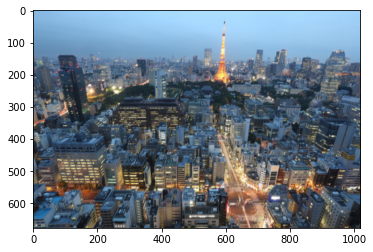

In [ ]:
plt.imshow(inv_norm(valid_imgs["lr"]).permute(1, 2, 0))

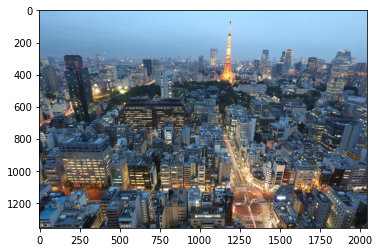

In [ ]:
plt.imshow(inv_norm(valid_imgs["hr"]).permute(1, 2, 0))

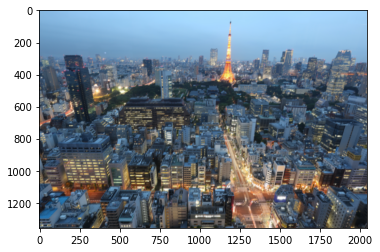

In [ ]:
plt.imshow(inv_norm(output_hr[0]).permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
# save_image(inv_norm(output_hr[0]), '/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR/best122.png')

In [ ]:
y_act = inv_norm(valid_imgs["hr"]).permute(1, 2, 0)
y_pred = inv_norm(output_hr[0]).permute(1, 2, 0).cpu().detach()
mse = torch.mean((y_pred - y_act) ** 2)
psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
print(psnr)

tensor(21.6570)


In [ ]:
png = Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/Kaido.png")
png.load() # required for png.split()

background = Image.new("RGB", png.size, (255, 255, 255))
background.paste(png, mask=png.split()[3]) # 3 is the alpha channel

background.save('/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/kaido.png', 'PNG', quality=80)
background.save('/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR/kaido.png', 'PNG', quality=80)

In [ ]:
lr_transform = transforms.Compose(
            [
                transforms.Resize((128, 96), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
img_lr = lr_transform(Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/" + "0880" + "x2.png"))
# save_image(img_lr, '/content/drive/My Drive/SRGAN/pres.png')
inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
input_lr = torch.unsqueeze(img_lr, dim=0)
with torch.no_grad():
    output_hr = generator(input_lr.to(device))
save_image(inv_norm(output_hr[0]), '/content/drive/My Drive/SRGAN/pres2.png')

In [ ]:
class ImageDataset2(Dataset):
    def __init__(self, paths, lr_shape, hr_shape):
        self.lr_height, self.lr_width = lr_shape
        self.hr_height, self.hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                # transforms.Resize((self.lr_height, self.lr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                # transforms.Resize((self.hr_height, self.hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.paths = paths

    def __getitem__(self, index):
        path = self.paths[index % len(self.paths)]
        img_hr = Image.open(path)
        img_lr = Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/" + path.split('/')[-1].split('.')[0] + "x2.png")
        # five_crop_lr = transforms.FiveCrop((self.lr_height, self.lr_width))
        # five_crop_hr = transforms.FiveCrop((self.hr_height, self.hr_width))
        # imgs_lr = five_crop_lr(img_lr)
        # imgs_hr = five_crop_hr(img_hr)
        # img_idx = np.random.randint(5)
        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.paths)

In [ ]:
valid_dataset_path = "/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR"
valid_paths = glob.glob(valid_dataset_path + "/*.*")
valid_dataset = ImageDataset2(valid_paths, (128, 128), (256, 256))

In [ ]:
for idx, path in enumerate(valid_dataset.paths):
    print(idx, path.split('/')[-1].split('.')[0])
    valid_imgs = valid_dataset[idx]
    inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
    input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
    with torch.no_grad():
        output_hr = generator(input_lr.to(device))
    save_image(inv_norm(output_hr[0]), '/content/drive/My Drive/SRGAN/Outputs3/{}.png'.format(path.split('/')[-1].split('.')[0]))

0 0897
1 0887
2 0806
3 0834
4 0896
5 0881
6 0828
7 0833
8 0877
9 0826
10 0879
11 0812
12 0809
13 0865
14 0882
15 0830
16 0892
17 0859
18 0858
19 0816
20 0836
21 0857
22 0824
23 0823
24 0810
25 0900
26 0884
27 0890
28 0835
29 0848
30 0869
31 0878
32 0860
33 0851
34 0870
35 0867
36 0898
37 0818
38 0814
39 0895
40 0856
41 0891
42 0829
43 0825
44 0853
45 0894
46 0863
47 0883
48 0822
49 0837
50 0849
51 0899
52 0807
53 0864
54 0845
55 0871
56 0804
57 0815
58 0813
59 0868
60 0893
61 0876
62 0889
63 0843
64 0862
65 0875
66 0885
67 0866
68 0839
69 0873
70 0820
71 0852
72 0819
73 0808
74 0802
75 0821
76 0811
77 0847
78 0838
79 0827
80 0844
81 0872
82 0880
83 0854
84 0831
85 0841
86 0832
87 0801
88 0805
89 0888
90 0861
91 0817
92 0803
93 0842
94 0855
95 0840
96 0874
97 0846
98 0886
99 0850


In [ ]:
psnr_mean = 0
rmse_mean = 0
for idx, path in enumerate(valid_dataset.paths):
    print(idx, path.split('/')[-1].split('.')[0])
    convert_tensor = transforms.ToTensor()
    gt_hr = convert_tensor(Image.open(path))
    pred_hr = convert_tensor(Image.open("/content/drive/My Drive/SRGAN/Outputs3/" + path.split('/')[-1].split('.')[0] + ".png"))
    rmse = torch.sqrt(torch.mean((gt_hr - pred_hr)**2))
    psnr_mean += 20 * torch.log10(1.0 / rmse)
    rmse_mean += rmse

psnr_mean = psnr_mean/len(valid_dataset.paths)
print(psnr_mean)
rmse_mean = rmse_mean/len(valid_dataset.paths)
print(rmse_mean)

0 0897
1 0887
2 0806
3 0834
4 0896
5 0881
6 0828
7 0833
8 0877
9 0826
10 0879
11 0812
12 0809
13 0865
14 0882
15 0830
16 0892
17 0859
18 0858
19 0816
20 0836
21 0857
22 0824
23 0823
24 0810
25 0900
26 0884
27 0890
28 0835
29 0848
30 0869
31 0878
32 0860
33 0851
34 0870
35 0867
36 0898
37 0818
38 0814
39 0895
40 0856
41 0891
42 0829
43 0825
44 0853
45 0894
46 0863
47 0883
48 0822
49 0837
50 0849
51 0899
52 0807
53 0864
54 0845
55 0871
56 0804
57 0815
58 0813
59 0868
60 0893
61 0876
62 0889
63 0843
64 0862
65 0875
66 0885
67 0866
68 0839
69 0873
70 0820
71 0852
72 0819
73 0808
74 0802
75 0821
76 0811
77 0847
78 0838
79 0827
80 0844
81 0872
82 0880
83 0854
84 0831
85 0841
86 0832
87 0801
88 0805
89 0888
90 0861
91 0817
92 0803
93 0842
94 0855
95 0840
96 0874
97 0846
98 0886
99 0850
tensor(23.4870)
tensor(0.0712)


In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2

In [ ]:
ssim_mean = 0
for idx, path in enumerate(valid_dataset.paths):
    print(idx, path.split('/')[-1].split('.')[0])
    # convert_tensor = transforms.ToTensor()
    gt_hr = cv2.imread(path)
    pred_hr = cv2.imread("/content/drive/My Drive/SRGAN/Outputs3/" + path.split('/')[-1].split('.')[0] + ".png")
    pred_hr = pred_hr/pred_hr.max()
    gt_hr = gt_hr/gt_hr.max()
    ssim_mean += ssim(gt_hr, pred_hr, data_range=gt_hr.max() - gt_hr.min(), channel_axis=2)

ssim_mean = ssim_mean/len(valid_dataset.paths)
print(ssim_mean)

0 0897
1 0887
2 0806
3 0834
4 0896
5 0881
6 0828
7 0833
8 0877
9 0826
10 0879
11 0812
12 0809
13 0865
14 0882
15 0830
16 0892
17 0859
18 0858
19 0816
20 0836
21 0857
22 0824
23 0823
24 0810
25 0900
26 0884
27 0890
28 0835
29 0848
30 0869
31 0878
32 0860
33 0851
34 0870
35 0867
36 0898
37 0818
38 0814
39 0895
40 0856
41 0891
42 0829
43 0825
44 0853
45 0894
46 0863
47 0883
48 0822
49 0837
50 0849
51 0899
52 0807
53 0864
54 0845
55 0871
56 0804
57 0815
58 0813
59 0868
60 0893
61 0876
62 0889
63 0843
64 0862
65 0875
66 0885
67 0866
68 0839
69 0873
70 0820
71 0852
72 0819
73 0808
74 0802
75 0821
76 0811
77 0847
78 0838
79 0827
80 0844
81 0872
82 0880
83 0854
84 0831
85 0841
86 0832
87 0801
88 0805
89 0888
90 0861
91 0817
92 0803
93 0842
94 0855
95 0840
96 0874
97 0846
98 0886
99 0850
0.6795320432685618
